In [1]:
# importando as bibliotecas

import numpy as np
import sympy as sym
import control as ct
from slycot import *
import matplotlib.pyplot as plt
import scienceplots
import latex
import pytask
import scipy as cp

# 1  Modelagem do sistema

In [2]:
# Parâmetros [Dissertação Gisele]
m = 1     # kilograma
m1 = 1    # kilograma
m2 = 1    # kilograma
l1 = 0.05 # metros
l2 = 0.05 # metros
g = 9.81  # m/s^2
f0 = 0.01
f1 = 0.007
f2 = 0.007
J1 = 0.00083 
J2 = 0.00083
Ts = 0.01
l = 0.45


In [3]:
"""# Parâmetros [Paper Jacob]
m = 1.5     # kilograma
m1 = 0.4    # kilograma
m2 = 0.22    # kilograma
l1 = 0.04064 # metros
l2 = 0.6878 # metros
g = 9.81  # m/s^2
f0 = 0.5
f1 = 0.2
f2 = 0.2
J1 = 0.0407
J2 = 0.359
Ts = 0.01
l = 0.45"""


'# Parâmetros [Paper Jacob]\nm = 1.5     # kilograma\nm1 = 0.4    # kilograma\nm2 = 0.22    # kilograma\nl1 = 0.04064 # metros\nl2 = 0.6878 # metros\ng = 9.81  # m/s^2\nf0 = 0.5\nf1 = 0.2\nf2 = 0.2\nJ1 = 0.0407\nJ2 = 0.359\nTs = 0.01\nl = 0.45'

In [3]:

# Simplificação
A01 =J1*J2*(m+m1+m2)+J1*l2*l2*m2*(m + m1)+J2*l1*l1*(m*m1+4*m*m2+m1*m2)
A02 = m*l1*l1*l2*l2*m1*m2
A0 = A01 + A02

A1 = g*l1*(m1+2*m2)
A2 = g*l2*m2

A3 = -J2*l1*(m1+2*m2)-l1*l2*l2*m1*m2
A4 = J2*(m+m1+m2)+m*l2*l2*m2 + l2*l2*m1*m2
A5 = -l1*l2*m2*(2*m+m1)

A6 = -l2*m2*(J1-l1*l1*m1)
A7 = -l1*l2*m2*(2*m+m1)
A8 = J1*(m+m1+m2)+l1*l1*m2*(m*m1 +4*m +m1)

B1 = J1*(J2 +l2*l2*m2) + J2*(l1*l1*m1+4*l1*l1*m2)+l1*l1*l2*l2*m1*m2
B2 = -J2*l1*m1-2*J2*l1*m2-l1*l2*l2*m1*m2
B3 = -J1*l2*m2+l1*l1*l2*m1*m2

# Matrizes de estado
A=np.array([[0, 0, 0, 1, 0, 0 ],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1],
            [0, -(A1*A3)/A0, -(A2*A6)/A0, 0, 0, 0],[0, -(A1*A4)/A0,-(A2*A7)/A0, 0, 0, 0],[0, -(A1*A5)/A0,-(A2*A8)/A0, 0, 0, 0]])
B=np.array([[0],[0],[0],[B1/A0],[B2/A0],[B3/A0]])
C=np.array([[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
D=0
Aa = np.array([[]])
sys = ct.ss(A,B,C,D)




In [4]:
A

array([[   0.        ,    0.        ,    0.        ,    1.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           1.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    1.        ],
       [   0.        ,   14.73466591,   -1.64374696,    0.        ,
           0.        ,    0.        ],
       [   0.        , -442.33526109,  147.64194295,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  442.92582886, -344.30101097,    0.        ,
           0.        ,    0.        ]])

In [5]:
# Discretizando a planta
sys_discreto = ct.c2d(sys, Ts, method='zoh')
Ad = np.array(sys_discreto.A)
Bd = np.array(sys_discreto.B)

In [5]:
type(sys)

control.statesp.StateSpace

In [6]:
print(sys_discreto)

<StateSpace>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00  7.33720376e-04 -8.10478923e-05  1.00000000e-02
       2.44974831e-06 -2.71677320e-07]
     [ 0.00000000e+00  9.77991778e-01  7.33381421e-03  0.00000000e+00
       9.92649467e-03  2.45103624e-05]
     [ 0.00000000e+00  2.20014426e-02  9.82861431e-01  0.00000000e+00
       7.35310872e-05  9.94276955e-03]
     [ 0.00000000e+00  1.46142716e-01 -1.59822453e-02  1.00000000e+00
       7.33720376e-04 -8.10478923e-05]
     [ 0.00000000e+00 -4.37998234e+00  1.45712802e+00  0.00000000e+00
       9.77991778e-01  7.33381421e-03]
     [ 0.00000000e+00  4.37138405e+00 -3.41244934e+00  0.00000000e+00
       2.20014426e-02  9.82861431e-01]]

B = [[ 3.88437813e-05]
     [-4.98620711e-04]
     [ 1.65235254e-04]
     [ 7.75604726e-03]
     [-9.93154714e-02]
     [ 3.25835785e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
    

numpy.ndarray

# 2 LQR


In [21]:
# Escolhendo Q e R
""" Cenário 1: O controle é barato (menos custo)
    Cenário 2: O controle é caro (maior custo)
    Cenário 3: Ignora o valor que custa a posição, preocupação é a posicao do pendulo(despreocupado com custos)
"""
cenario = 2

if cenario == 1:
        Q = np.array([[10,0,0,0,0,0],[0,20,0,0,0,0],[0,0,20,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([0.1])
        
elif cenario == 2:
        Q = np.array([[100,0,0,0,0,0],[0,200,0,0,0,0],[0,0,200,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
        R = np.array([1])
        
elif cenario == 3:
        Q = np.array([[1,0,0,0,0,0],[0,10,0,0,0,0],[0,0,10,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([10])
elif cenario == 4:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([1])
else:
        print('Método desconhecido')
        




In [22]:
[K,S,E] = ct.lqr(A,B,Q,R)
K

array([[ 10.        , -12.49462922,   1.9512867 ,   9.0274632 ,
         -1.1039786 ,  -0.41177231]])

In [23]:
# GANHO LQR
#[K,S,E] = ct.lqr(A,B,Q,R)
[K,S,E] = ct.dlqr(Ad,Bd,Q,R)
K

array([[ 9.19988502, -9.35150437,  1.59112988,  8.35193238, -1.06914389,
        -0.37000945]])

In [24]:
# GANHO DARE
[K_d, S_d, E_d] = ct.dare(Ad,Bd,Q,R,method='slycot')
E_d

array([[ 9.19988502, -9.35150437,  1.59112988,  8.35193238, -1.06914389,
        -0.37000945]])

In [10]:
# Para rastreamento
#k1 = K[0][0]

In [47]:
print('Os ganhos K do Controlador são: ',K)

Os ganhos K do Controlador são:  [[  71.29070959 -156.33442677    9.84756101   50.56508042   -3.19096728
    -4.14276634]]


In [25]:
#controlador Lqr discreto
Ac = Ad - Bd @ K
#Bc = Bd*k1
Bc = Bd
Cc =  np.eye(6)
Dc = np.zeros_like(Bc)
Wip = ct.ss(Ac, Bc, Cc, Dc,Ts)

In [49]:
Bd @ K

array([[ 2.76920073e-03, -6.07262028e-03,  3.82516506e-04,
         1.96413893e-03, -1.23949235e-04, -1.60920710e-04],
       [-3.55470243e-02,  7.79515830e-02, -4.91019787e-03,
        -2.52127963e-02,  1.59108237e-03,  2.06566910e-03],
       [ 1.17797385e-02, -2.58319588e-02,  1.62716425e-03,
         8.35513393e-03, -5.27260290e-04, -6.84531050e-04],
       [ 5.52934113e-01, -1.21253720e+00,  7.63781486e-02,
         3.92185153e-01, -2.47492930e-02, -3.21314915e-02],
       [-7.08027043e+00,  1.55264273e+01, -9.78015163e-01,
        -5.02189480e+00,  3.16912420e-01,  4.11440792e-01],
       [ 2.32290643e+00, -5.09393507e+00,  3.20868777e-01,
         1.64759127e+00, -1.03973133e-01, -1.34986152e-01]])

In [50]:
# Auto Valores
auto_valores = ct.poles(Wip)
auto_valores

array([0.76094444+0.2639577j , 0.76094444-0.2639577j ,
       0.88669354+0.14522223j, 0.88669354-0.14522223j,
       0.98498555+0.01585484j, 0.98498555-0.01585484j])

In [51]:
polos = ct.poles(Wip)
polos

array([0.76094444+0.2639577j , 0.76094444-0.2639577j ,
       0.88669354+0.14522223j, 0.88669354-0.14522223j,
       0.98498555+0.01585484j, 0.98498555-0.01585484j])

In [11]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz de controlabilidade: 6


Matrix([
[  3.88437813038502e-5, 0.000115772863622379, 0.000190466742827359, 0.000261566913824604, 0.000327903743276531, 0.000388555438773389],
[-0.000498620710872838, -0.00147149101297509, -0.00237272557931563, -0.00315939801542793, -0.00379550293804701, -0.00425409579994399],
[ 0.000165235254387502, 0.000468101221582499, 0.000690172168305373,  0.00078417921680752, 0.000712284217549139, 0.000448961073428659],
[  0.00775604725906874,  0.00760502602835415,  0.00731098925527181,  0.00688945190513186,  0.00636247735163702,  0.00575731388628023],
[   -0.099315471360343,  -0.0944660337075228,  -0.0850610952510404,  -0.0716697030327761,  -0.0550995812134601,   -0.036345452776279],
[   0.0325835785369049,   0.0270965394213194,   0.0165239304368125,   0.0016419947904163,   -0.016449897457841,   -0.036402474847977]])

In [12]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cc)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                  0.0,                   0.0,  0.0,                  0.0,                   0.0],
[0.0,                  1.0,                   0.0,  0.0,                  0.0,                   0.0],
[0.0,                  0.0,                   1.0,  0.0,                  0.0,                   0.0],
[0.0,                  0.0,                   0.0,  1.0,                  0.0,                   0.0],
[0.0,                  0.0,                   0.0,  0.0,                  1.0,                   0.0],
[0.0,                  0.0,                   0.0,  0.0,                  0.0,                   1.0],
[1.0, 0.000733720376049382,  -8.10478922770698e-5, 0.01,  2.44974831146228e-6,  -2.71677320385038e-7],
[0.0,    0.977991778268197,   0.00733381421081525,  0.0,  0.00992649467136372,   2.45103624070375e-5],
[0.0,   0.0220014426324458,     0.982861430904178,  0.0,  7.35310872211125e-5,   0.00994276955200199],
[0.0,    0.146142716106745,   -0.0159822452723519,  1.0, 0.00073

In [16]:
# Polos do sistema
polos = ct.poles(Wip)
zeros_s = ct.zeros(Wip)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

Os polos do sistema são:  [0.93658019+0.24916084j 0.93658019-0.24916084j 0.95377188+0.11206732j
 0.95377188-0.11206732j 0.98840744+0.01175349j 0.98840744-0.01175349j] Os zeros do sistema são:  []


In [ ]:
# Pólos do sistema
plt.figure(figsize=(4, 4),dpi=330) 
ct.pzmap(Wip ,plot=True,title ='Polos do sistema',grid=True,color='r',marker_size=7,xlim=[0.35,1.1],ylim=[-0.27,0.27],scaling=True)

In [44]:
#plt.style.available

# Simulações

In [45]:
#plt.style.reload_library

In [13]:
plt.style.use(['science','no-latex'])

In [28]:
# Simulação 1

# Condições iniciais:
"""
Posição angular inicial de (5°)[0.0872 rad] para ambos os pêndulos e posicão inicial
nula para o carro
"""

x0 = np.array([[0.0],[np.deg2rad(.01)],[np.deg2rad(1)],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 5, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)
#td,yd = ct.step_response(Wip, X0=x0)


"""altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0],'-r', label='Posição x')
subplots[1].plot(t,y[1], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(t,y[2], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()"""

"altura = 4\nlargura = 9\nsubplots = plt.subplots(1, 1, figsize=(largura, altura))\nsubplots[1].plot(t,y[0],'-r', label='Posição x')\nsubplots[1].plot(t,y[1], '-k',label='ângulo phi1')\n#subplots[1].stem(t,y[1], label='ângulo phi1')\nsubplots[1].plot(t,y[2], label='ângulo phi2')\n#subplots[1].stem(t,y[2], label='ângulo phi2')\nsubplots[1].set_title('Resposta Inicial')\nsubplots[1].set_xlabel('Tempo (s)')\nsubplots[1].set_ylabel('Posição (m)')\nsubplots[1].grid(True)\nsubplots[1].legend()\n\nplt.show()"

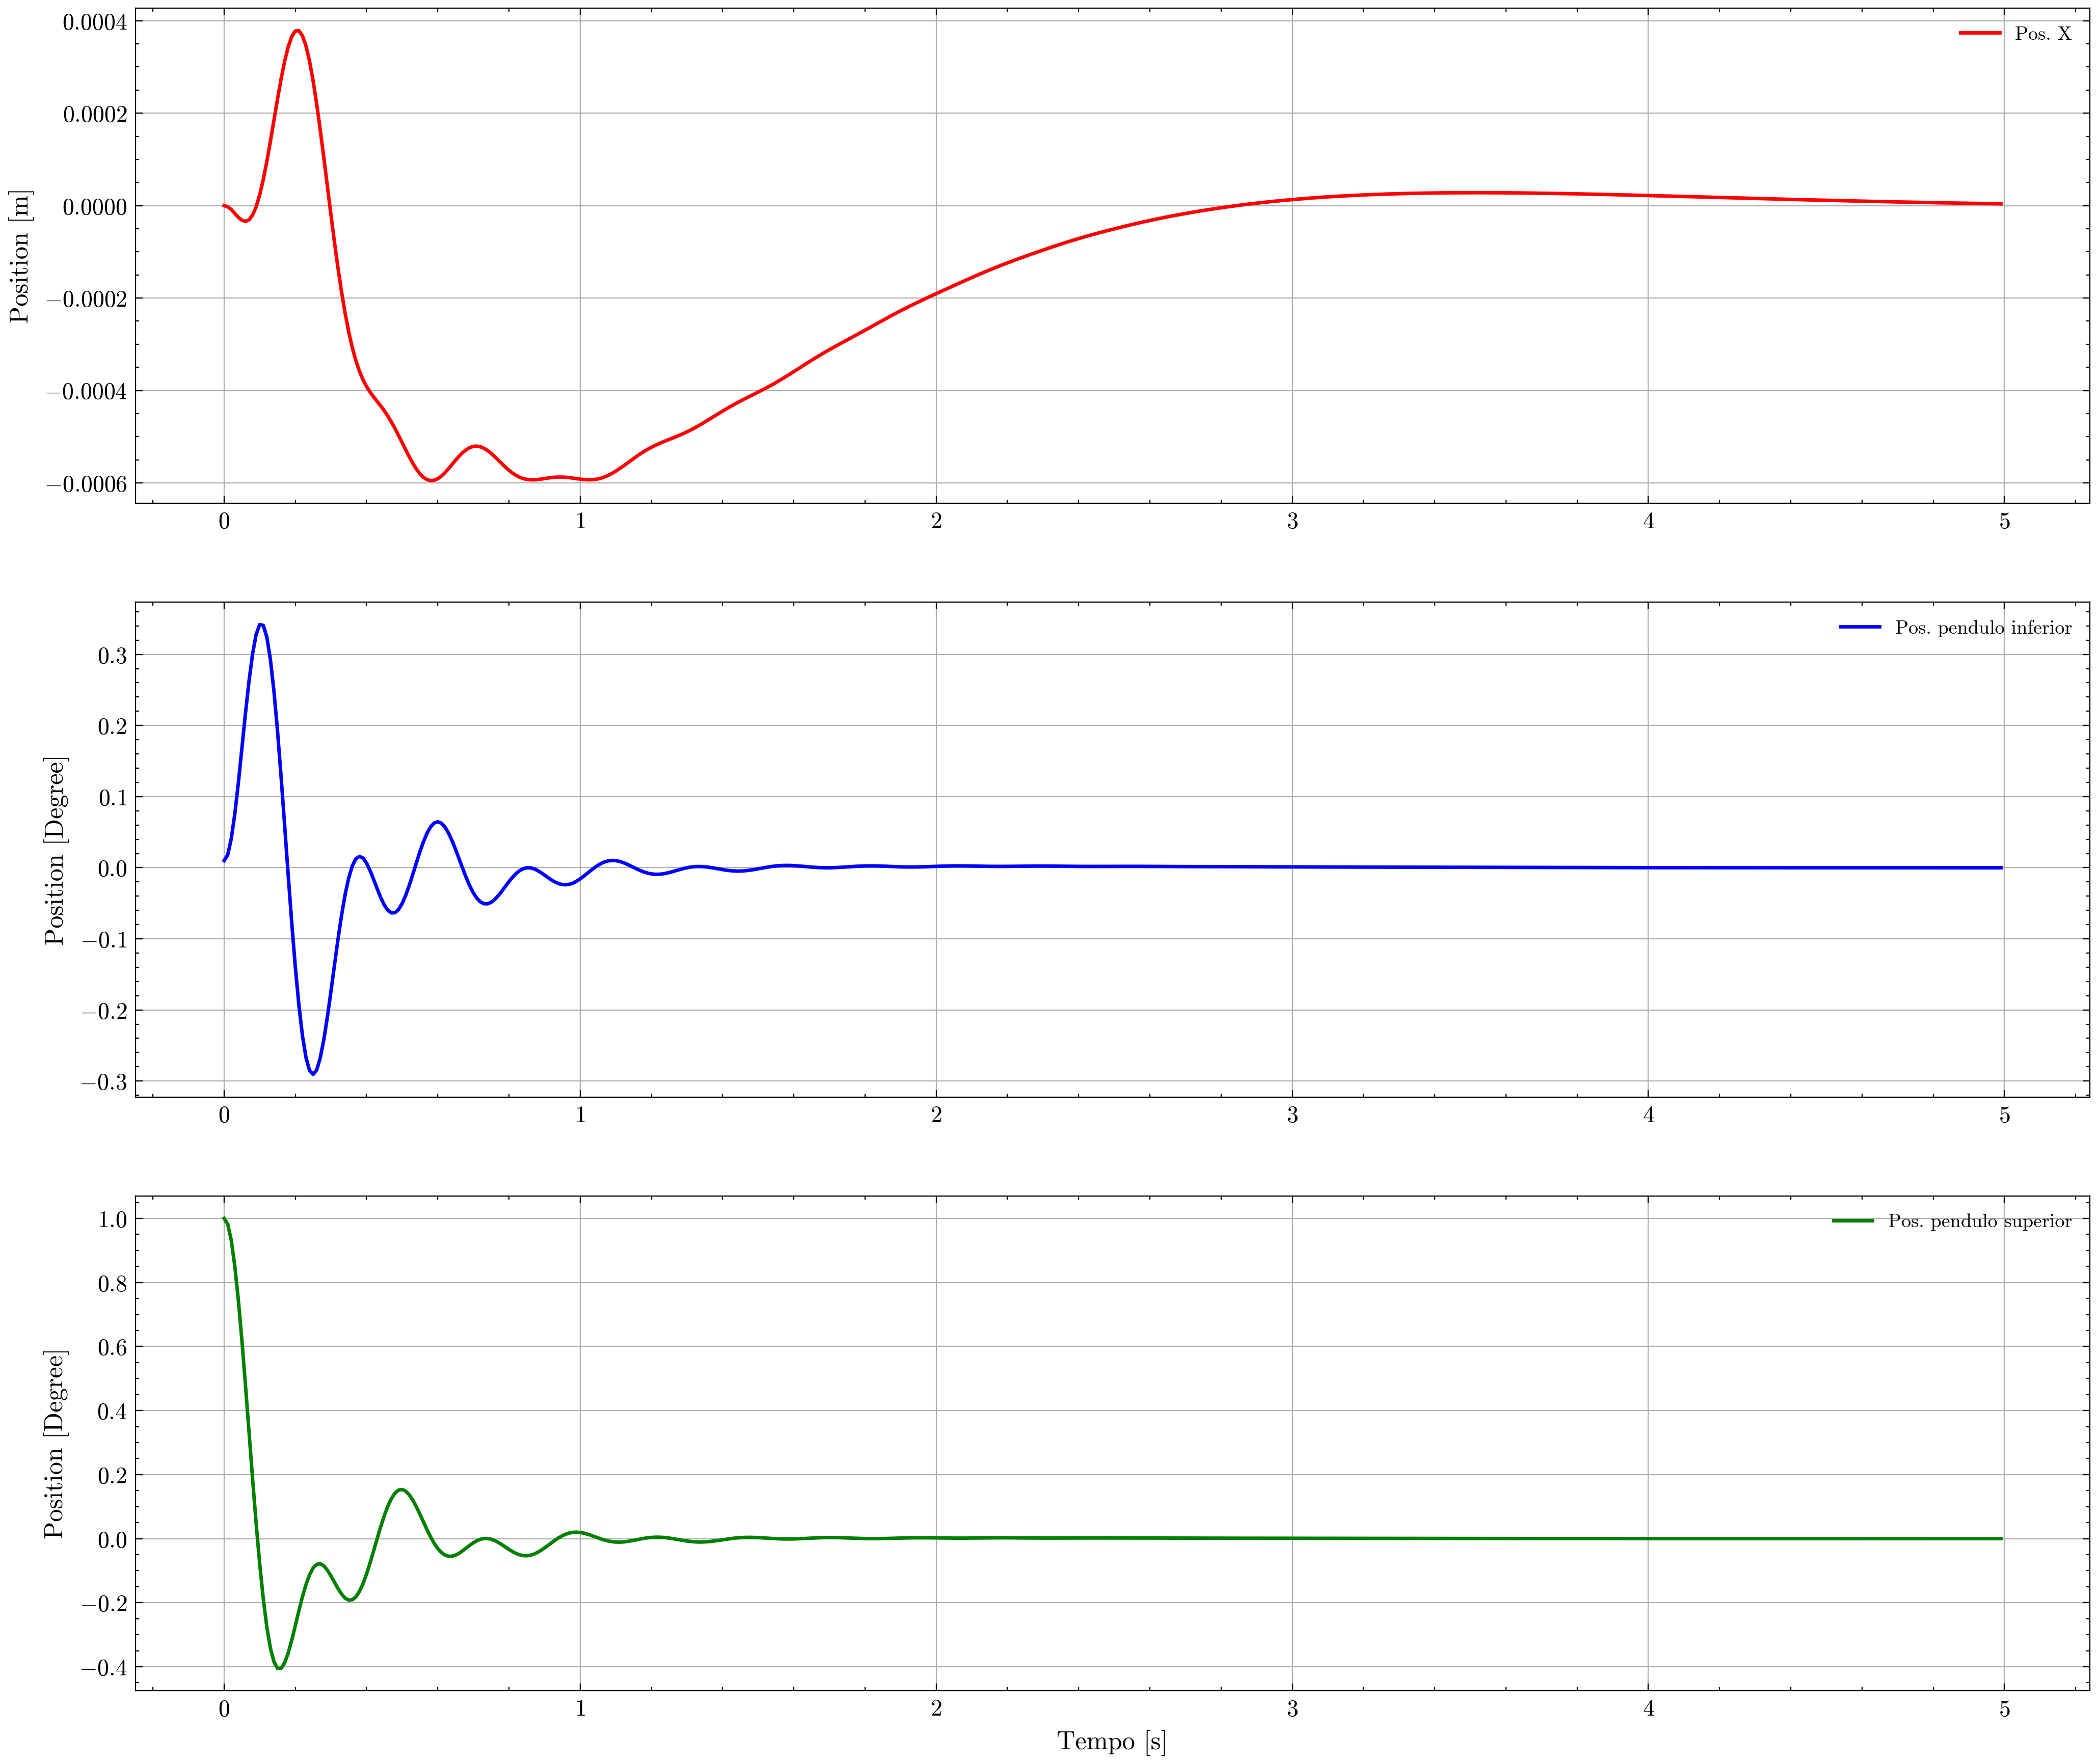

In [29]:
plt.figure(figsize=(15,13), dpi=330)
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, y[0],'r',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, np.rad2deg(y[1]),'b',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, np.rad2deg(y[2]),'g',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

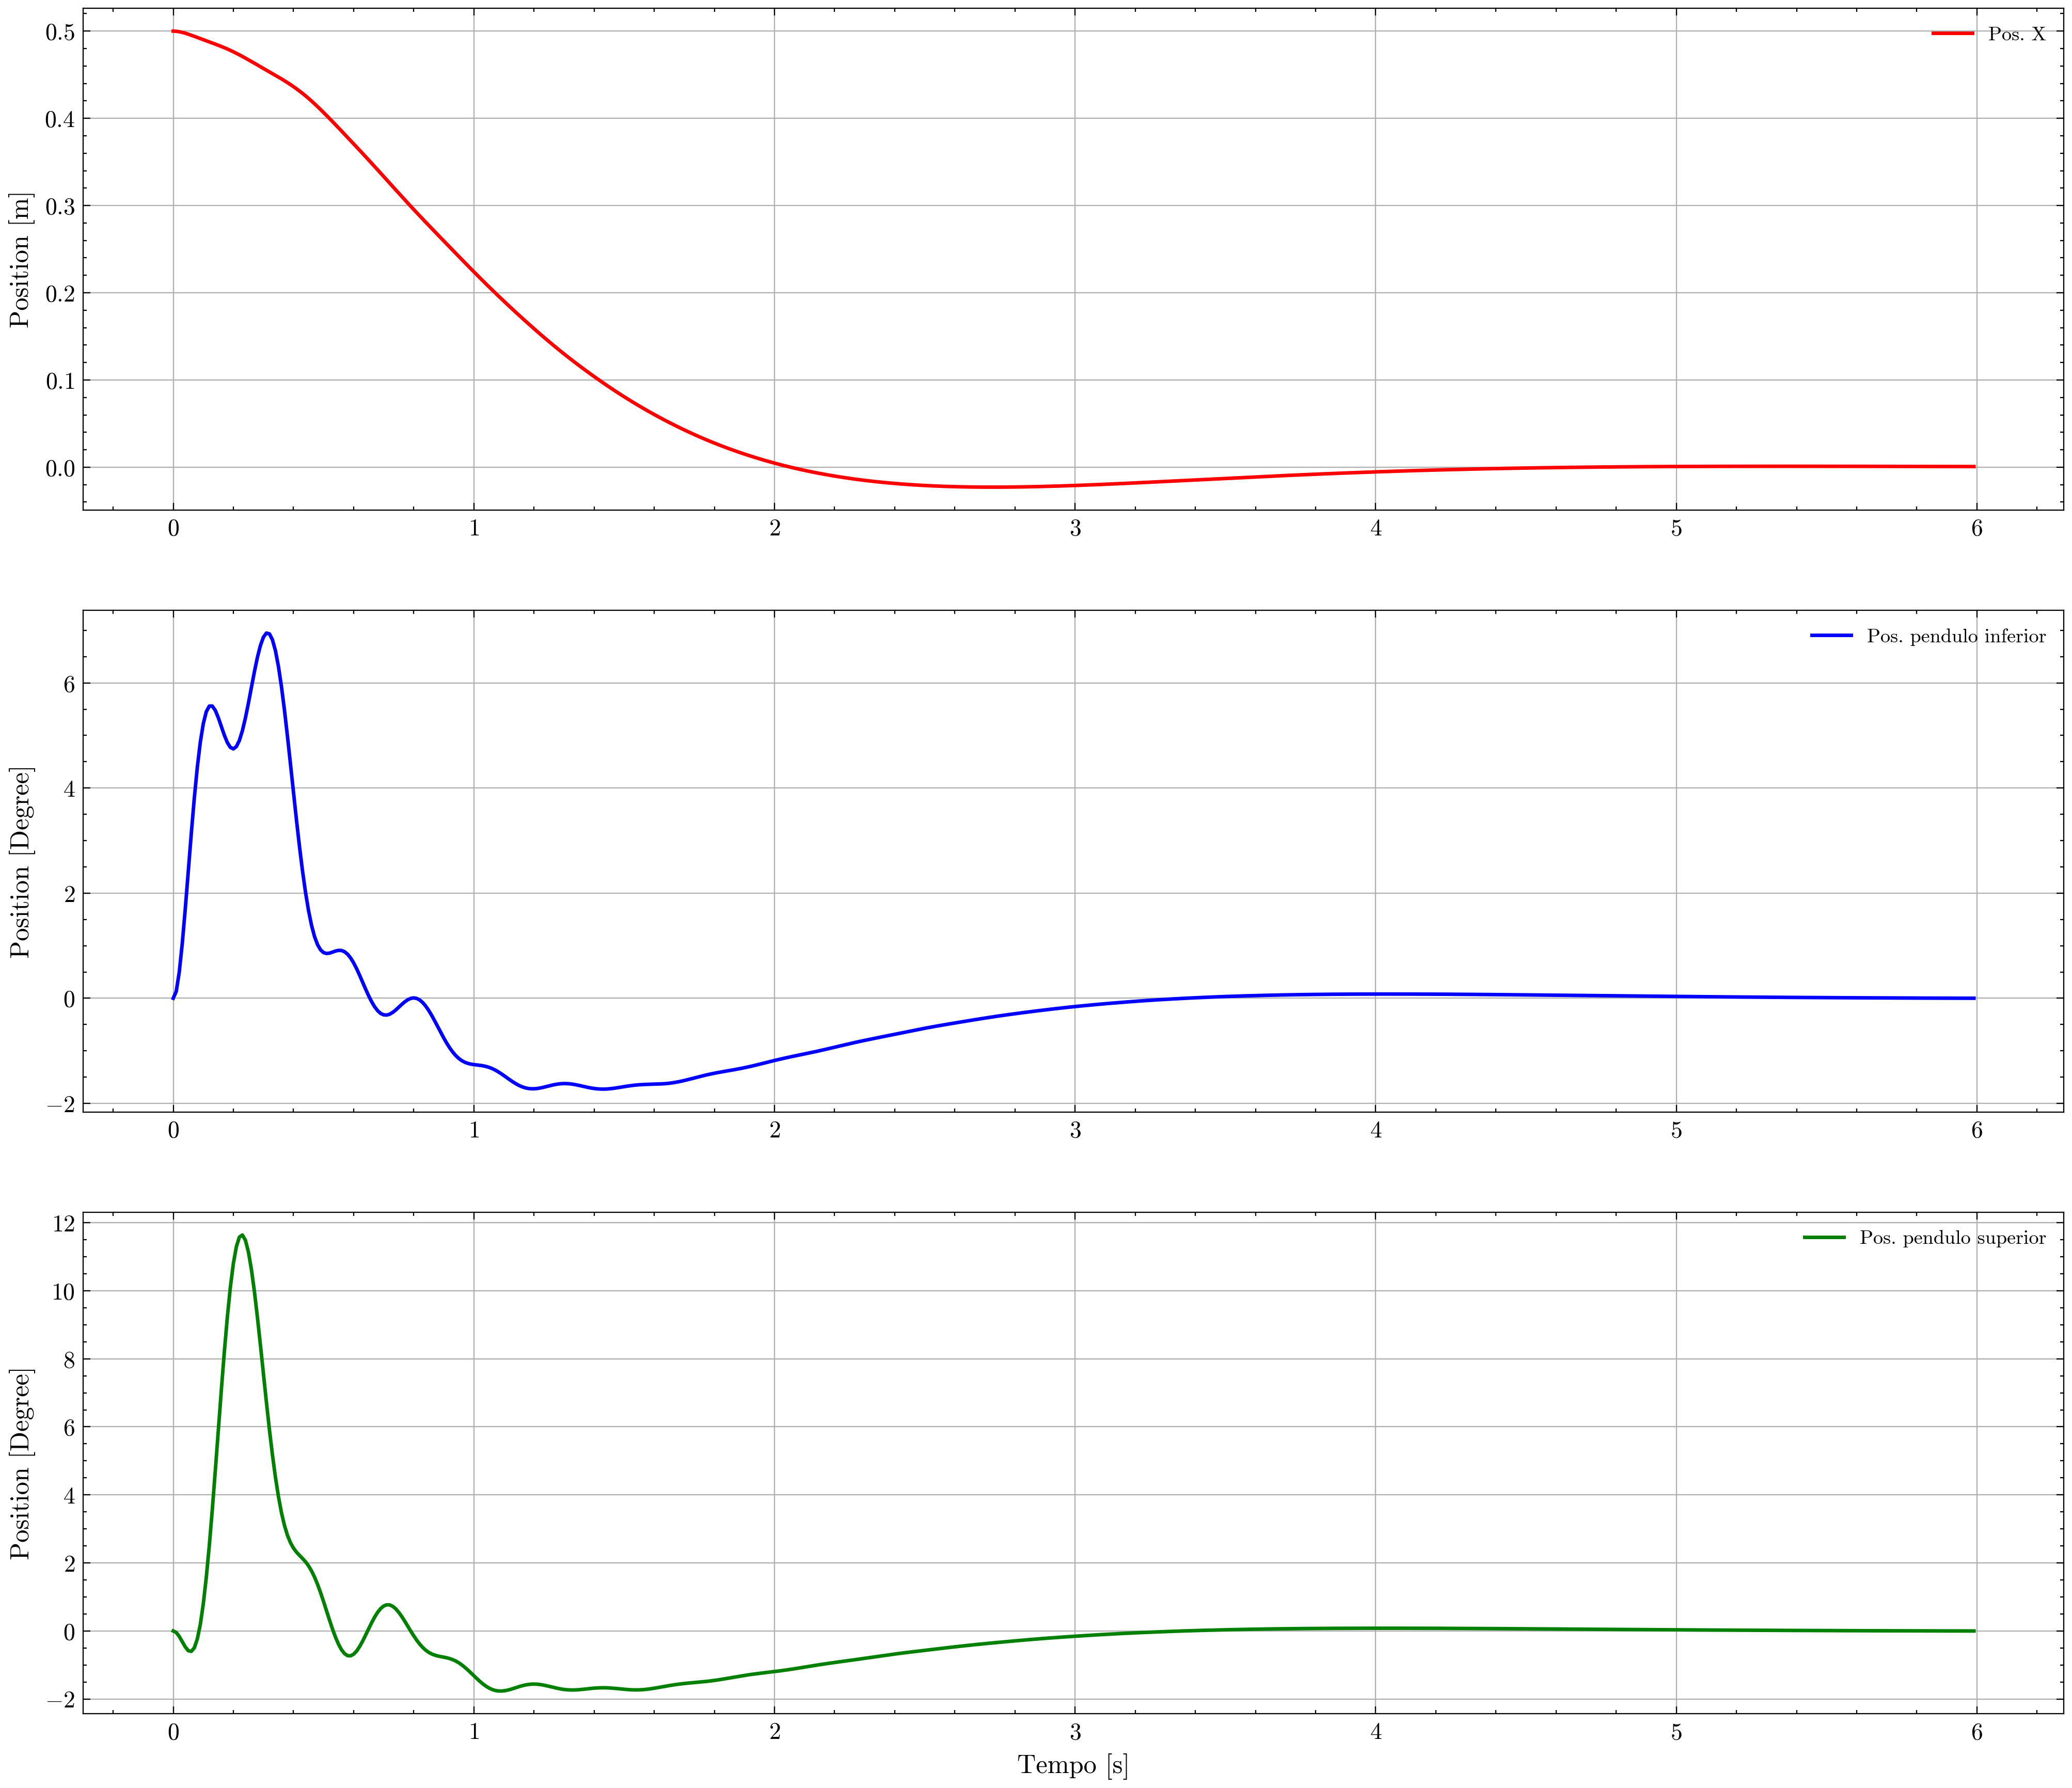

In [24]:
# Simulação 2


# Condições iniciais:
"""
Posição angular inicial de (0°)[0.0872 rad] para ambos os pêndulos e posicão inicial
0.5 m para o carro
"""

x0 = np.array([[0.5],[0],[0],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 6, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)

plt.figure(figsize=(15,13), dpi=330)
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, y[0],'r',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, np.rad2deg(y[1]),'b',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, np.rad2deg(y[2]),'g',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

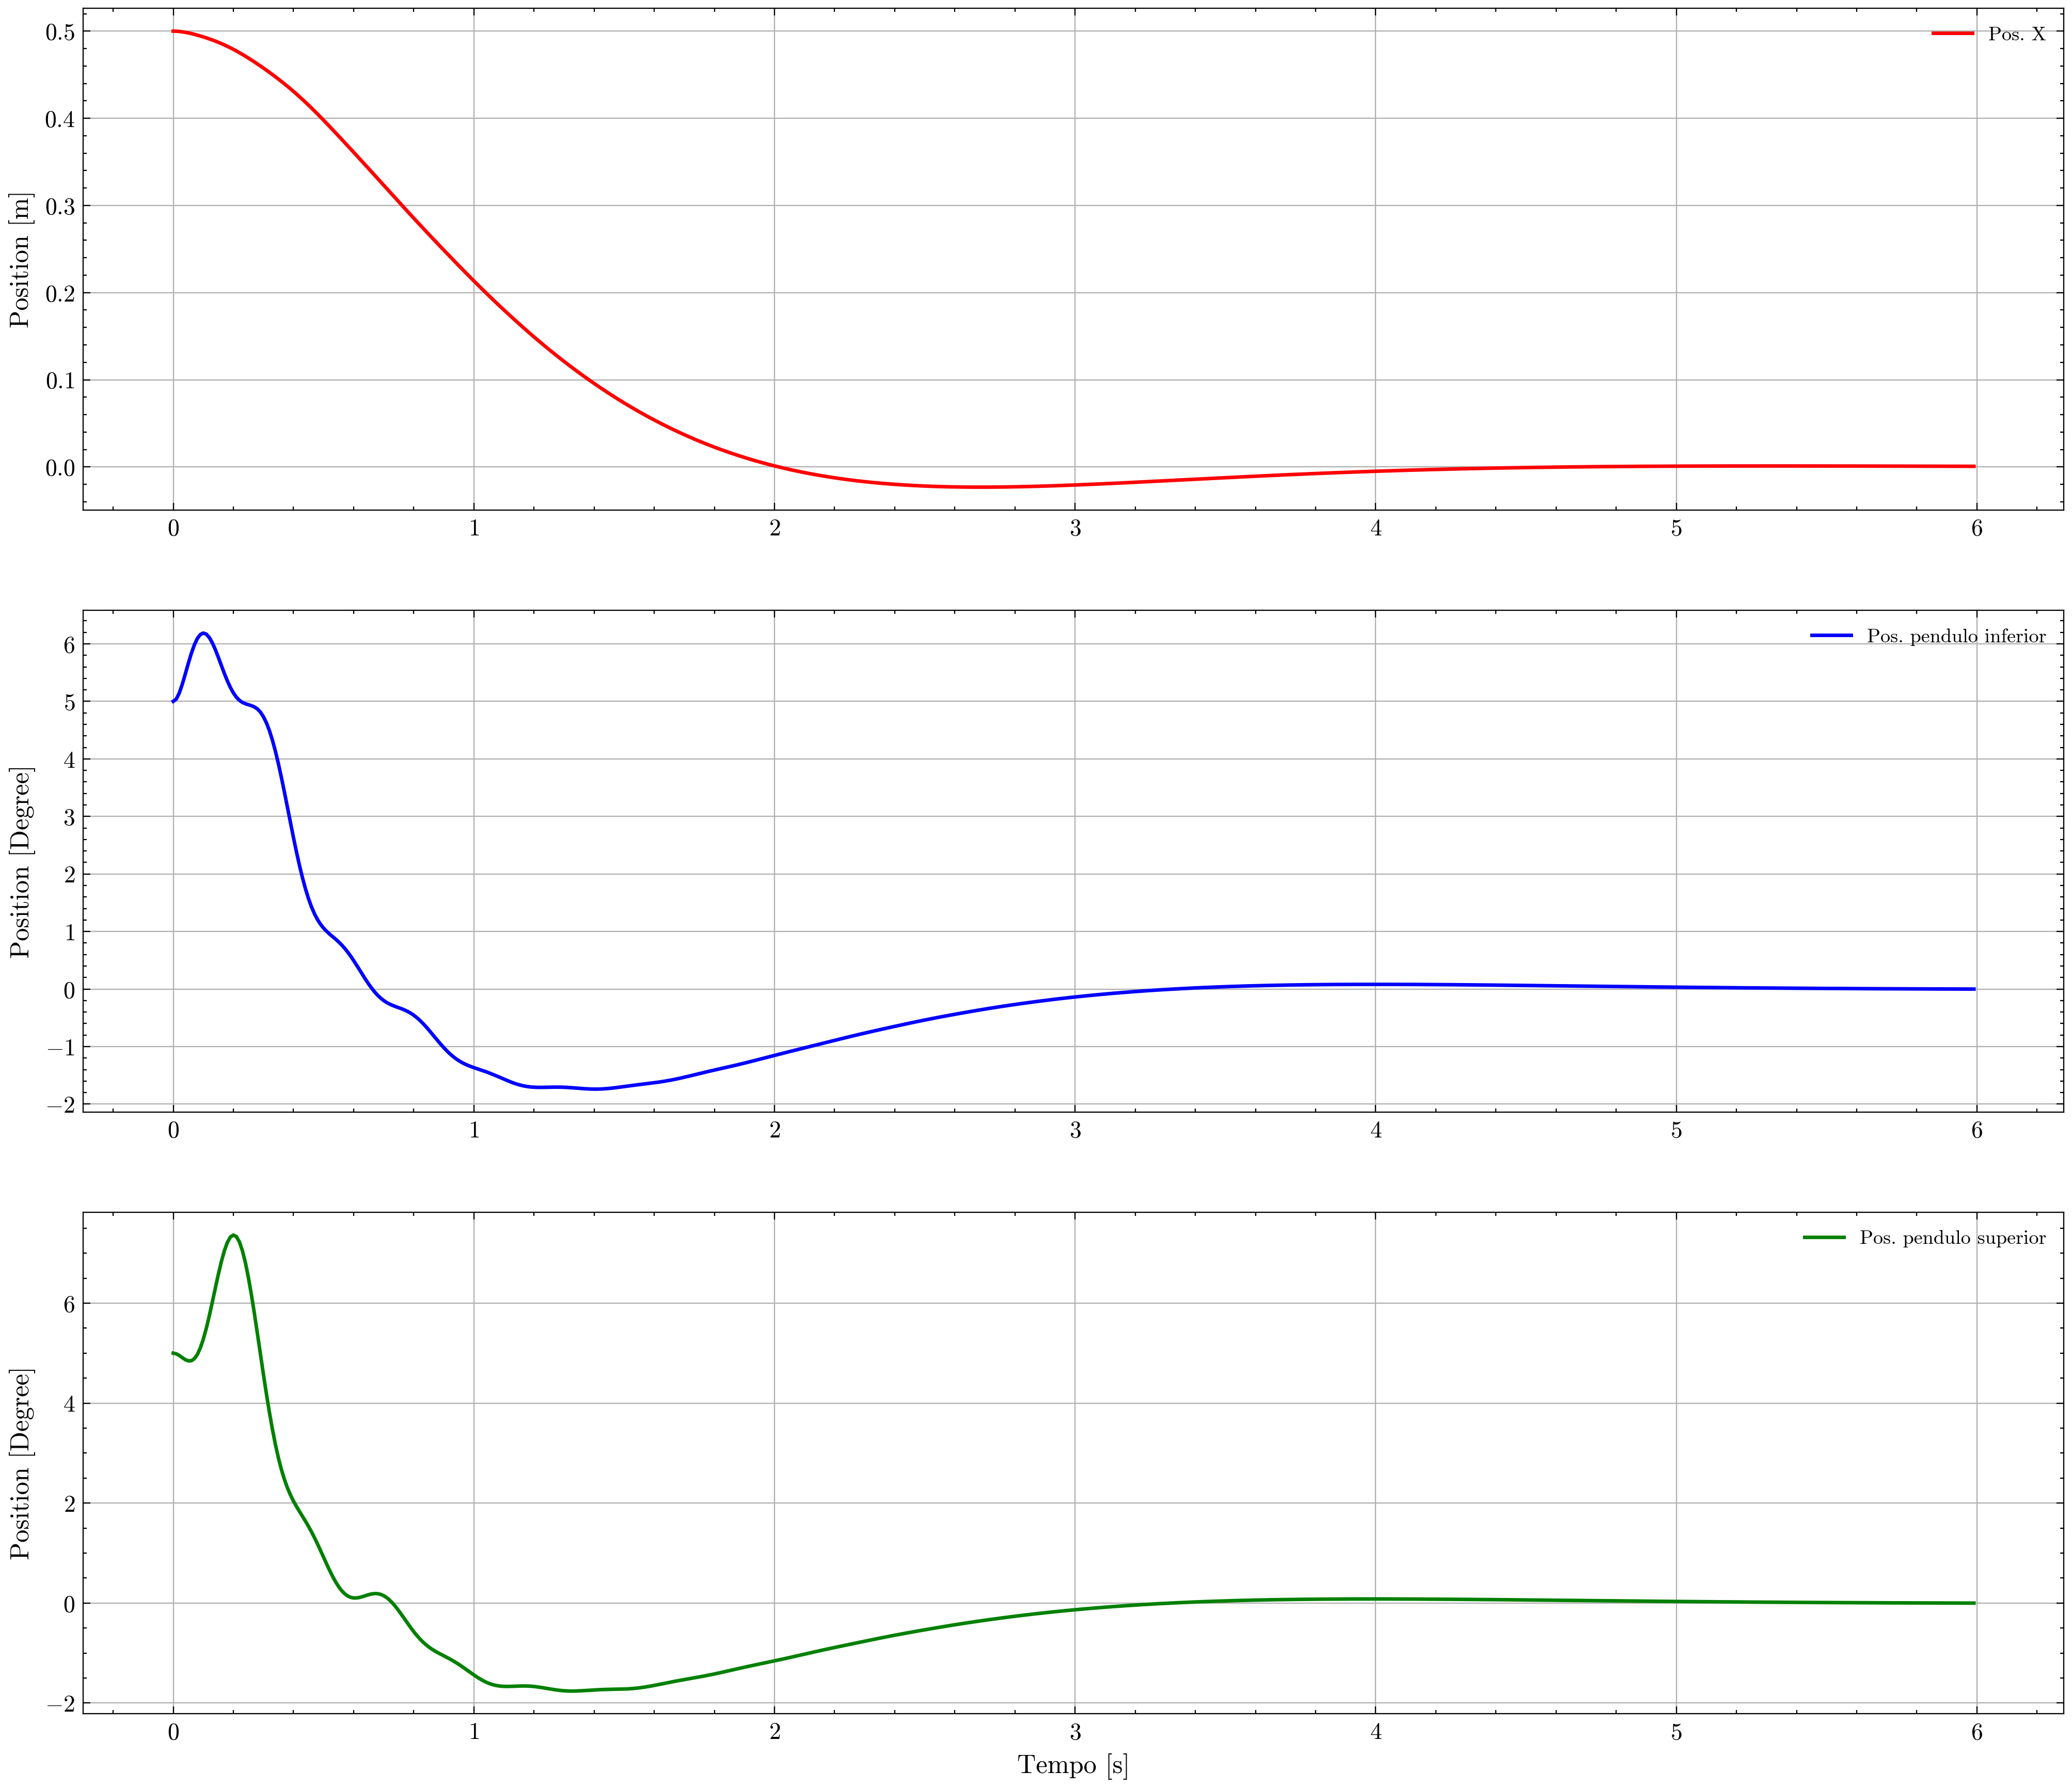

In [25]:
# Simulação 3

# Condições iniciais:
"""
Posição angular inicial de (5°)[0.0872 rad] para ambos os pêndulos e posicão inicial
0.5 m para o carro
"""

x0 = np.array([[0.5],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 6, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)

plt.figure(figsize=(15,13), dpi=330)
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, y[0],'r',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, np.rad2deg(y[1]),'b',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, np.rad2deg(y[2]),'g',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Degree]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

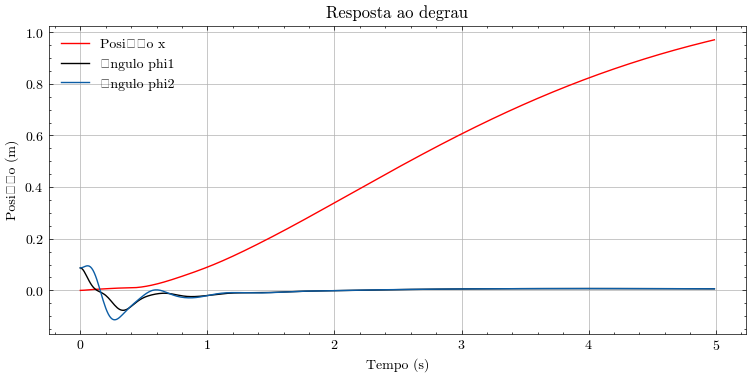

In [14]:
s,p = ct.step_response(Wip,T=t,X0=x0)

altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(s,p[0][0],'-r', label='Posição x')
subplots[1].plot(s,p[1][0], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(s,p[2][0], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta ao degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

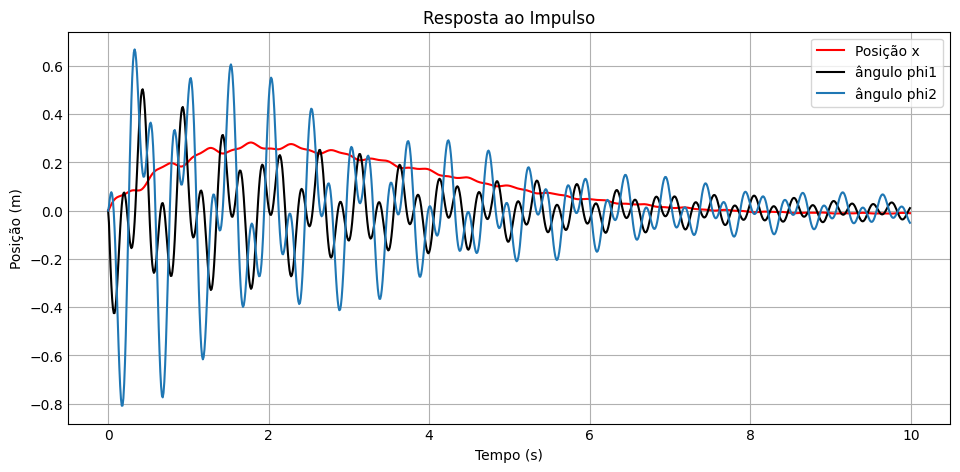

In [32]:
i,r = ct.impulse_response(Wip,T=t)
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(i,r[0][0],'-r', label='Posição x')
subplots[1].plot(i,r[1][0], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(i,r[2][0], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta ao Impulso')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()

plt.show()

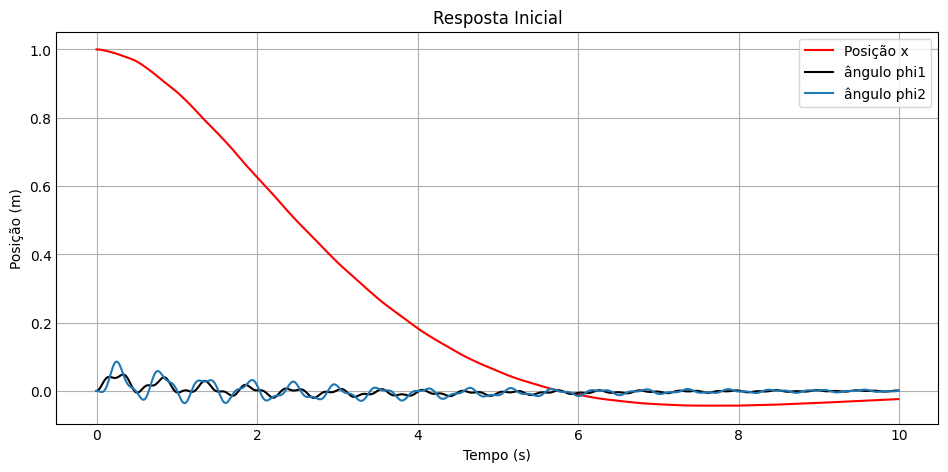

In [33]:
# Simulação 2

# Condições iniciais:
"""
Posição angular inicial nula para ambos os pêndulos e posicão inicial
em x = 0.5 m para o carro
"""

x0 = np.array([[1.],[0.0],[0.0],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 10, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)
s,p = ct.step_response(Wip,T=t,X0=x0)

altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0],'-r', label='Posição x')
subplots[1].plot(t,y[1], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(t,y[2], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

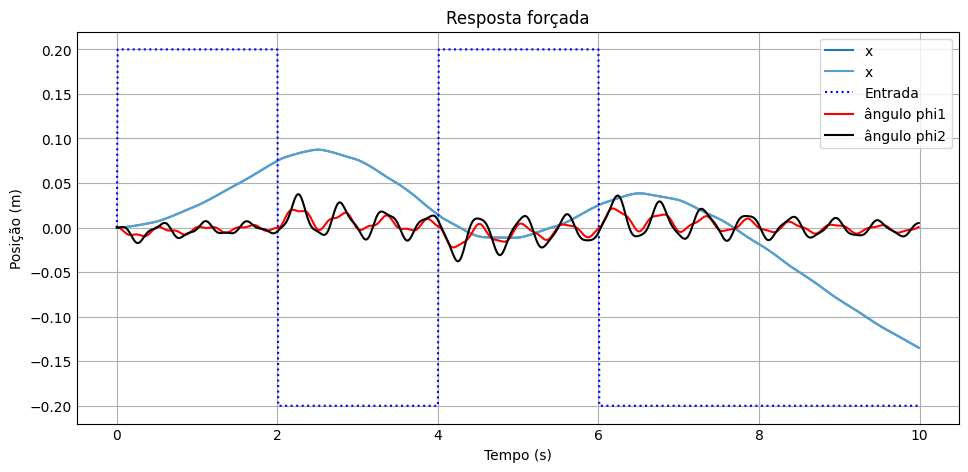

In [34]:
# Simulação 3

# Aplicando entrada 

# Definindo a função de entrada personalizada
def input_signal(t, t_entrada_apply, amplitude_pert):
    if t> 0 and t<=2:
        sinal_entrada =amplitude_pert
    elif t> 2 and t<=4:
        sinal_entrada = -amplitude_pert
    elif t> 4 and t<=6:
        sinal_entrada =amplitude_pert
    elif t>6 and t<=10:
        sinal_entrada=-amplitude_pert
    else:
        sinal_entrada = 0
        
    return sinal_entrada

# Instante de tempo em que a entrada será aplicada
t_entrada_apply = 2

# Amplitude da entrada
amplitude_pert =0.2


# Aplicando a entrada
u = [input_signal(t_i, t_entrada_apply, amplitude_pert) for t_i in t]
#u = np.square(np.sin(2*np.pi*t))
#u = 8
# Calculando a resposta do sistema com a entrada aplicada
#t_out, y_out, w_out = ct.forced_response(Wip, T=t, U=u)
#t_out, y_out= ct.forced_response(Wip, T=t, U=u)
t_out, y_out= ct.input_output_response(Wip,t,U=u)
# Plotando a saída
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t_out, y_out[0],label='x')
subplots[1].plot(t_out, y_out[0],label='x')
subplots[1].plot(t_out, u,':b',label='Entrada')
subplots[1].plot(t_out, y_out[1],'-r', label='ângulo phi1')
subplots[1].plot(t_out, y_out[2],'-k',label='ângulo phi2')
subplots[1].set_title('Resposta forçada')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()